In [1]:
import numpy as np
import scipy.io as spio
from matplotlib import pyplot as plt
from matplotlib import cm
import glob
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags
import numpy as np
from util.models import MODELS
from util.tasks import TASKS
import tensorflow_probability as tfp

from tfds_data.aff_nist import AffNist
from calibration_util import *
from notebook_utils import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
sns.set_style("whitegrid")

from tqdm import tqdm

def visualization(x, y,count,index):
    x = np.reshape(x, (40, 40))
    
    plt.subplot(1,count,index)
    plt.imshow(x, cmap=cm.Greys_r)
    plt.title(y)
    plt.axis('off')   

def visualization_overlap(x0,x1, y0,y1,count,index):
    r = np.reshape(x0, (40, 40))
    g = np.reshape(x1, (40, 40))
    b = np.zeros_like(r)
    rgb = np.stack([r,g,b],-1)
    
    plt.subplot(1,count,index)
    plt.imshow(rgb)
    plt.title('R:('+ str(y0)+','+str(y1)+')')
    plt.axis('off')   


[nltk_data] Downloading package punkt to /home/dehghani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
chkpt_dir='../tf_ckpts'
task_name = 'mnist40'
mnist = TASKS[task_name](get_task_params(), data_dir='../data')

chkpt_dir='../tf_ckpts'
task_name = 'affnist'
affnist = TASKS[task_name](get_task_params(), data_dir='../data')

(64, 40, 40, 1)


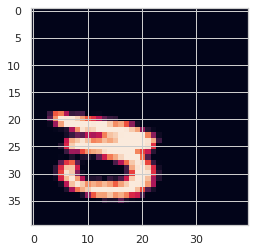

(64, 40, 40, 1)


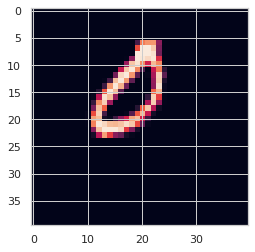

(64, 40, 40, 1)


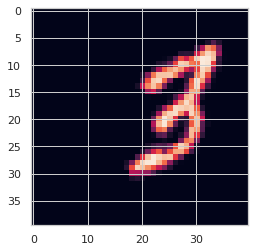

(64, 40, 40, 1)


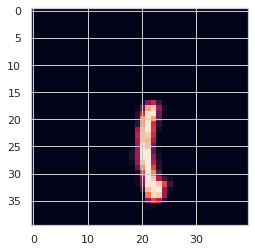

(64, 40, 40, 1)


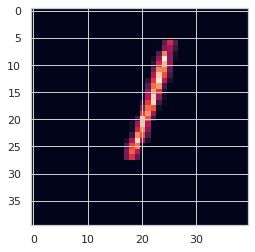

(64, 40, 40, 1)


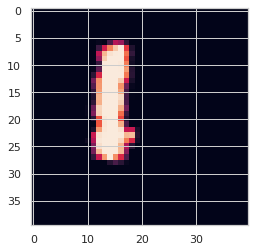

(64, 40, 40, 1)


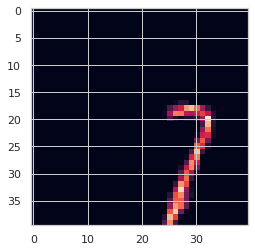

(64, 40, 40, 1)


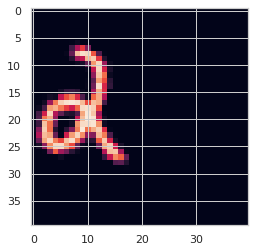

(64, 40, 40, 1)


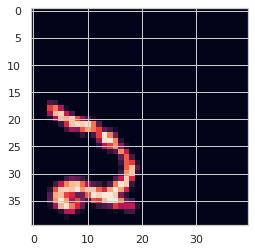

(64, 40, 40, 1)


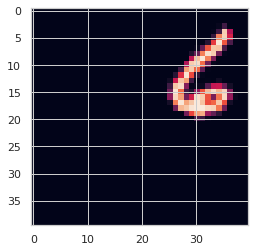

In [3]:
count = 10
for x,y in affnist.test_dataset:
    print(x.shape)
    #visualization(x[1].numpy(),y[1].numpy(),1,1)
    plt.imshow(x[0,...,0])
    plt.show()
    count -= 1
    if count <= 0:
        break

(64, 40, 40, 1)


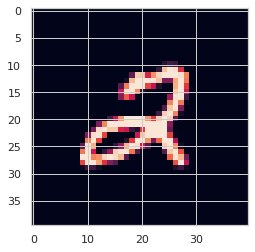

(64, 40, 40, 1)


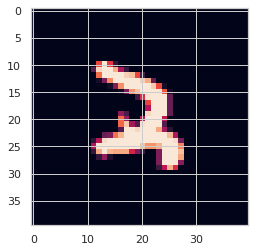

(64, 40, 40, 1)


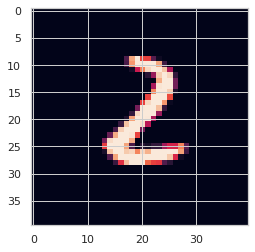

(64, 40, 40, 1)


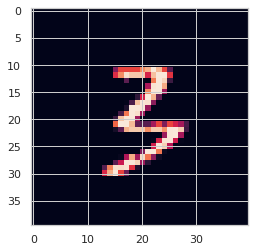

(64, 40, 40, 1)


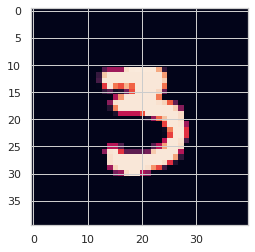

(64, 40, 40, 1)


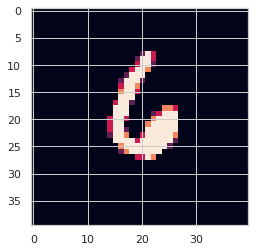

(64, 40, 40, 1)


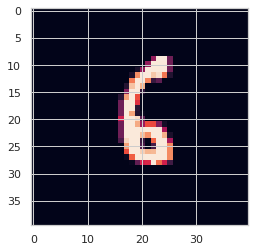

(64, 40, 40, 1)


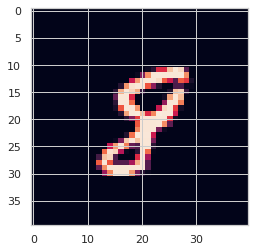

(64, 40, 40, 1)


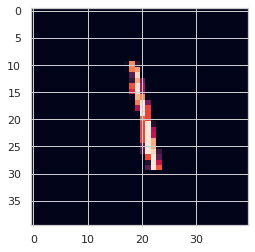

(64, 40, 40, 1)


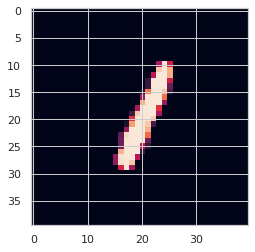

In [4]:
count = 10
for x,y in mnist.valid_dataset:
    print(x.shape)
    #visualization(x[1].numpy(),y[1].numpy(),1,1)
    plt.imshow(x[0,...,0])
    plt.show()
    count -= 1
    if count <= 0:
        break

In [5]:
config={'exp_name':'test',
    'model_config':'rsnt_mnist1',
    'task_name':'mnist40',
    'model_name':'cl_vff',
    'chkpt_dir':'../tf_ckpts',
    'learning_rate': 0.001
    }

task = TASKS[config['task_name']](get_task_params(batch_size=16), data_dir='../data')

hparams = get_model_params(task, config['model_name'], config['model_config'])
print(hparams)

model, _ = get_model(config, task, hparams, 0)

model config: rsnt_mnist1
{'hidden_dim': 512, 'pool_size': 3, 'filters': [32, 32, 32, 32], 'kernel_size': [(3, 3), (3, 3), (3, 3), (3, 3)], 'hidden_dropout_rate': 0.2, 'input_dropout_rate': 0.0, 'num_res_net_blocks': 2}
No checkpoint found ../tf_ckpts/mnist40/cl_vff_h-512_d-3_hdrop-0.2_indrop-0.0_rsnt_mnist1_0.001_test


In [49]:
class VanillaFF(tf.keras.models.Sequential):
  def __init__(self, hparams, scope="cl_vff", *inputs, **kwargs):
    if 'cl_token' in kwargs:
      del kwargs['cl_token']

    super(VanillaFF, self).__init__()
    self.scope = scope
    self.hparams = hparams

    self.model_name = '_'.join([self.scope,
                                'h-' + str(self.hparams.hidden_dim),
                                'd-' + str(self.hparams.depth),
                                'hdrop-' + str(self.hparams.hidden_dropout_rate),
                                'indrop-' + str(self.hparams.input_dropout_rate)])

    self.regularizer = tf.keras.regularizers.l1_l2(l1=0.00001,
                                                   l2=0.00001)
    self.create_vars()
    self.rep_index = 1
    self.rep_layer = -1



  def create_vars(self):
    self.flat = tf.keras.layers.Flatten()
    #self.batch_norm = tf.keras.layers.BatchNormalization()
    #self.batch_norm.trainable = True
    self.indrop = tf.keras.layers.Dropout(self.hparams.input_dropout_rate)
    self.activation = tf.keras.layers.Activation('relu')
    self.hidden_layers = []
    self.hidden_batch_norms = []
    self.hidden_dropouts = []
    for i in np.arange(self.hparams.depth):
      self.hidden_layers.append(tf.keras.layers.Dense(self.hparams.hidden_dims[1],
                                     activation=None, #'relu',
                                     kernel_regularizer=self.regularizer))
      self.hidden_batch_norms.append(tf.keras.layers.BatchNormalization())
      self.hidden_batch_norms[i].trainable = True
      self.hidden_dropouts.append(tf.keras.layers.Dropout(self.hparams.hidden_dropout_rate))
      
    
    self.final_dense = tf.keras.layers.Dense(self.hparams.output_dim,
                                   kernel_regularizer=self.regularizer)


  def call(self, inputs, padding_symbol=None, training=None, **kwargs):
    x = inputs # self.batch_norm0(inputs, training=training, **kwargs)
    x = self.flat(x, **kwargs)
    #x = self.batch_norm(x, training=training, **kwargs)
    x = self.indrop(x, training=training, **kwargs)
    for i in np.arange(self.hparams.depth):
      x = self.hidden_layers[i](x, training=training, **kwargs)
      x = self.hidden_batch_norms[i](x, training=training, **kwargs)
      x = self.activation(x)
      x = self.hidden_dropouts[i](x, training=training, **kwargs)

    logits = self.final_dense(x, training=training, **kwargs)

    return logits


  def detailed_call(self, inputs, padding_symbol=None, training=None, **kwargs):
    layer_activations = []
    x = self.flat(inputs, **kwargs)
    x = self.batch_norm(x, training=training, **kwargs)
    x = self.indrop(x, training=None, **kwargs)
    layer_activations.append(x)

    for i in np.arange(self.hparams.depth):
      x = self.hidden_layers[i](x, training=None, **kwargs)
      x = self.hidden_batch_norms[i](x, training=None, **kwargs)
      x = self.hidden_dropouts[i](x, training=None, **kwargs)
      layer_activations.append(x)

    pnltimt = x
    logits = self.final_dense(x, training=None, **kwargs)

    return logits, pnltimt, layer_activations


In [53]:
hparams.depth=3
hparams.hidden_dims=[512, 128, 32]
hparams.hidden_dropout_rate = 0.1

model = VanillaFF(hparams)
for x,y in task.train_dataset:
    print(x.shape, y.shape)
    break
out = model(inputs=x, training=True)
print(out.shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=task.get_loss_fn(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

(16, 40, 40, 1) (16,)
(16, 10)
Model: "vanilla_ff_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         multiple                  0         
_________________________________________________________________
dropout_52 (Dropout)         multiple                  0         
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
dense_51 (Dense)             multiple                  204928    
_________________________________________________________________
dense_52 (Dense)             multiple                  16512     
_________________________________________________________________
dense_53 (Dense)             multiple                  16512     
_________________________________________________________________
batch_normalization_50

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=task.get_loss_fn(),
              metrics=task.metrics())

history = model.fit(task.train_dataset,
                  epochs=20,
                  steps_per_epoch=task.n_train_batches,
                  validation_steps=affnist.n_valid_batches,
                  validation_data=affnist.valid_dataset,
                  verbose=2
                  )



Train for 3750 steps, validate for 5000 steps
Epoch 1/20
3750/3750 - 37s - loss: 0.4089 - classification_loss: 0.3502 - sparse_categorical_accuracy: 0.8915 - val_loss: 20.3562 - val_classification_loss: 20.2917 - val_sparse_categorical_accuracy: 0.1357
Epoch 2/20
3750/3750 - 36s - loss: 0.2840 - classification_loss: 0.2144 - sparse_categorical_accuracy: 0.9333 - val_loss: 22.0374 - val_classification_loss: 21.9630 - val_sparse_categorical_accuracy: 0.1419
Epoch 3/20
3750/3750 - 35s - loss: 0.2593 - classification_loss: 0.1810 - sparse_categorical_accuracy: 0.9450 - val_loss: 22.9292 - val_classification_loss: 22.8472 - val_sparse_categorical_accuracy: 0.1528
Epoch 4/20
3750/3750 - 35s - loss: 0.2459 - classification_loss: 0.1610 - sparse_categorical_accuracy: 0.9501 - val_loss: 22.7489 - val_classification_loss: 22.6609 - val_sparse_categorical_accuracy: 0.1760
Epoch 5/20
3750/3750 - 35s - loss: 0.2349 - classification_loss: 0.1448 - sparse_categorical_accuracy: 0.9550 - val_loss: 24.0

In [55]:
model.evaluate(affnist.test_dataset, steps=affnist.n_test_batches)

5000/5000 [==============================] - 15s 3ms/step - loss: 28.6245 - classification_loss: 28.5121 - sparse_categorical_accuracy: 0.2014


[28.624486144638063, 28.512085, 0.20135625]